### Generate Graph Stucture from Vector Data

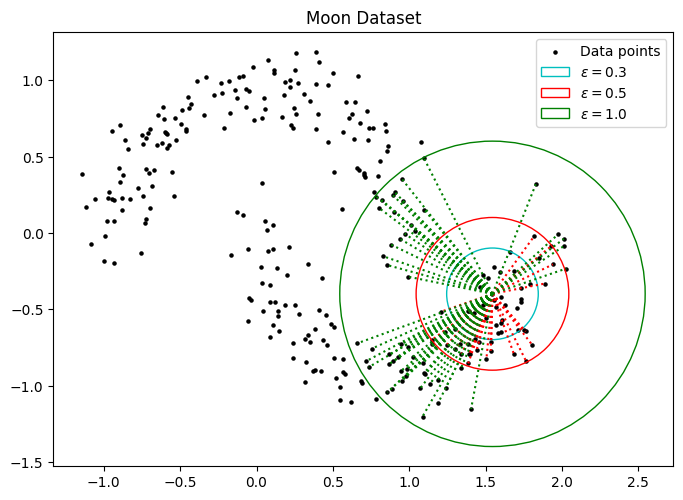

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from util import moon
from sklearn.metrics import pairwise_distances

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(8, 32))

n, noise = 500, 0.3
data, length = moon(n, noise)
x = data[:, 0]
y = data[:, 1]

DISTANCES = [0.3, 0.5, 1.0]
COLORS = ['c', 'r', 'g']

# Select a reference point (point 250)
p_200 = data[250]

# Compute pairwise distances between all points and the reference point
distances = pairwise_distances(data, [p_200])

# Plot scatter plot of the data points
ax.scatter(x, y, c='black', s=5, label="Data points")

# Draw circles and connect nearby points
for i, distance in enumerate(DISTANCES):
    circle = plt.Circle((p_200[0], p_200[1]), distance, color=COLORS[i], fill=False, label=rf'$\epsilon = {distance}$')
    ax.add_patch(circle)  # Add the circle to the axis

    # Find points within the distance range and plot lines to connect them
    nearby_points = np.where((distances < distance) & (distances >= DISTANCES[i - 1] if i > 0 else 0))[0]
    
    for j in nearby_points:
        if j != 300:  # Avoid connecting to the same point
            ax.plot([p_200[0], data[j, 0]], [p_200[1], data[j, 1]], color=COLORS[i], linestyle='dotted')

# Set aspect ratio to be equal for both axes
ax.set_aspect('equal', adjustable='box')
ax.set_title("Moon Dataset")

# Add legend
ax.legend()

plt.savefig("eps-boom.png", dpi = 300)

# Show the plot
plt.show()


Distance = 0.3, Number of edges = 2892
Distance = 0.5, Number of edges = 5886
Distance = 1.0, Number of edges = 14744


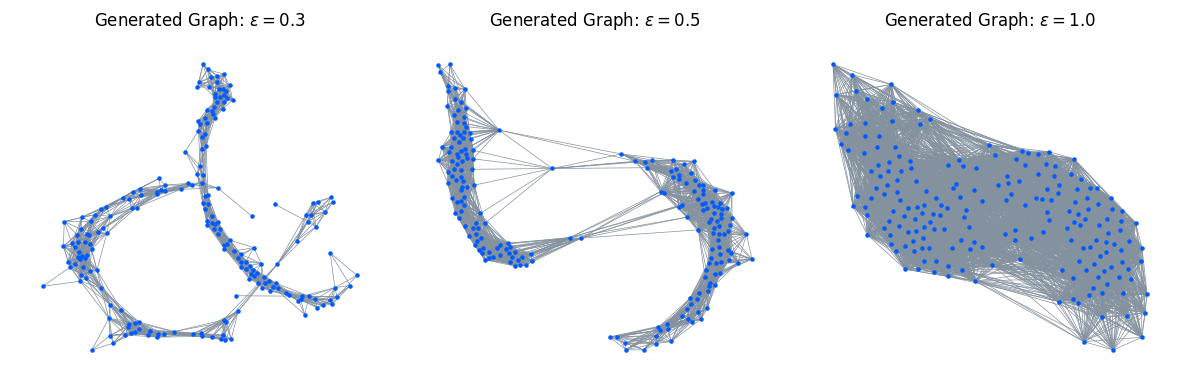

In [18]:
import os
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.auto import tqdm
import torch

# from util import Net, GIN, GAT, moon, stationary, reconstruct, dG
from util import moon

fig = plt.figure(figsize=(12, 4)) 

np.random.seed(0)
torch.manual_seed(0)

n = 200
noise = 0.5
DISTANCES = [0.3, 0.5, 1.0] 

x, n = moon(n, noise)
n_train = int(n * 0.7)
train_ind = torch.randperm(n)[:n_train]
test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))

D = pairwise_distances(x)

for i, DISTANCE in enumerate(DISTANCES):
    A_binary = np.where((D <= DISTANCE) & (D != 0), 1, 0)
    
    fr, to = np.where(A_binary == 1)
    edges = list(zip(fr, to))
    
    print(f"Distance = {DISTANCE}, Number of edges = {len(edges)}")
    
    G = nx.Graph()
    G.add_edges_from([(fr[i], to[i]) for i in range(len(fr))])
    
    pos = nx.spring_layout(G, k=0.18, seed=0)
    
    plt.subplot(1, 3, i + 1) 
    nx.draw(G, pos=pos, node_size=5, node_color='#005aff', edge_color='#84919e', width=0.5)
    plt.title(rf"$\text{{Generated Graph: }} \epsilon = {DISTANCE}$", fontsize=12)  

plt.tight_layout()
plt.show()


### Using tSNE, GCN, GIN and GAT to generate graph structure from vector data

In [ ]:
import os
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy.sparse import csr_matrix
import networkx as nx
from tqdm.auto import tqdm
import random
from scipy.linalg import orthogonal_procrustes

import torch
import torch.optim as optim
from torch_geometric.data import Data
from scipy.sparse import hstack
from sklearn.manifold import TSNE

from util import Net, GIN, GAT, moon, stationary, reconstruct, dG

np.random.seed(0)
torch.manual_seed(0)

n = 5000
m = 500
DISTANCE = 0.2

x, n = moon(n)
n_train = int(n * 0.7)
train_ind = torch.randperm(n)[:n_train]
test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))
K = int(np.sqrt(n) * np.log2(n) / 10)
D = pairwise_distances(x)

A_binary = np.where(D <= DISTANCE, 1, 0)

fr, to = np.where(A_binary == 1)
edges = list(zip(fr, to))

random_edges = random.sample(edges, K * n)
fr = [edge[0] for edge in random_edges]
to = [edge[1] for edge in random_edges]

A = csr_matrix((np.ones(len(fr)) / K, (fr, to)), shape=(n, n))

print(len(fr), len(to), A.shape)


edge_index = np.vstack([fr, to])
edge_index = torch.tensor(edge_index, dtype=torch.long)

X = torch.tensor([[K, n] for i in range(n)], dtype=torch.float)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

X = torch.tensor([[K, n] for i in range(n)], dtype=torch.float, device=device)
edge_index = torch.tensor(edge_index, dtype=torch.long, device=device)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
for i in tqdm(range(100)):
    pr = stationary(A)
    pr = np.maximum(pr, 1e-9)
    rec_orig = reconstruct(K, pr, n, m, fr, to)
    rec_orig = torch.FloatTensor(rec_orig).to(device) 
    g = net(torch.FloatTensor([(n - 3000) / 3000]).to(device))
    rec = rec_orig * (g ** 0.5)
    loss = dG(torch.FloatTensor(x).to(device)[train_ind], rec[train_ind])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x, rec.detach().cpu().numpy())
rec_proposed = rec.detach().cpu().numpy() @ R.T
loss_proposed = float(dG(torch.FloatTensor(x).to(device), rec))

net = GIN(m).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for epoch in tqdm(range(100)):
    ind = torch.eye(n, device=device)[:, torch.randperm(n)[:m]]
    X_extended = torch.hstack([X, ind])
    data = Data(x=X_extended, edge_index=edge_index)
    rec = net(data)
    loss = dG(torch.FloatTensor(x).to(device)[train_ind], rec[train_ind])
    # print(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x, rec.detach().cpu().numpy())
rec_GIN = rec.detach().cpu().numpy() @ R.T
loss_GIN = float(dG(torch.FloatTensor(x).to(device), rec))

net = GAT(m).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for epoch in tqdm(range(100)):
    ind = torch.eye(n, device=device)[:, torch.randperm(n)[:m]]
    X_extended = torch.hstack([X, ind])
    data = Data(x=X_extended, edge_index=edge_index)
    rec = net(data)
    loss = dG(torch.FloatTensor(x).to(device)[train_ind], rec[train_ind])
    # print(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x, rec.detach().cpu().numpy())
rec_GAT = rec.detach().cpu().numpy() @ R.T
loss_GAT = float(dG(torch.FloatTensor(x).to(device), rec))

ind = torch.eye(n, device=device)[:, torch.randperm(n)[:m]]
X_extended = torch.hstack([X, ind]).cpu().numpy()
X_embedded = TSNE(n_components=2, random_state=0, init='pca').fit_transform(X_extended)
loss_tSNE = float(dG(torch.FloatTensor(x).to(device), torch.FloatTensor(X_embedded).to(device)))



c = x[:, 0].argsort().argsort()
fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(2, 3, 1)
ax.scatter(x[:, 0], x[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('#eeeeee')
txt = ax.text(0.05, 0.05, 'Ground Truth', color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='#eeeeee')])

visible = plt.imread('./imgs/visible.png')
visible_ax = fig.add_axes([0.24, 0.77, 0.1, 0.1], anchor='NE', zorder=1)
visible_ax.imshow(visible)
visible_ax.axis('off')

G = nx.DiGraph()
G.add_edges_from([(fr[i], to[i]) for i in range(len(fr))])
ax = fig.add_subplot(2, 3, 2)
pos = nx.spring_layout(G, k=0.18, seed=0)
nx.draw_networkx(G, ax=ax, pos=pos, node_size=0.5, node_color='#005aff', labels={i: '' for i in range(n)}, edge_color='#84919e', width=0.0005, arrowsize=0.1)
txt = ax.text(0.05, 0.05, 'Input Graph', color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
ax.set_rasterization_zorder(3)

ax = fig.add_subplot(2, 3, 3)
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'tSNE(X) $Loss = {:.2f}$'.format(loss_tSNE), color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

ax = fig.add_subplot(2, 3, 4)
ax.scatter(rec_proposed[:, 0], rec_proposed[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'Proposed $Loss = \\mathbf{' + f'{loss_proposed:.3f}' + '}$', color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

ax = fig.add_subplot(2, 3, 5)
ax.scatter(rec_GIN[:, 0], rec_GIN[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'GIN $Loss = {:.2f}$'.format(loss_GIN), color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

ax = fig.add_subplot(2, 3, 6)
ax.scatter(rec_GAT[:, 0], rec_GAT[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'GAT $Loss = {:.2f}$'.format(loss_GAT), color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

fig.subplots_adjust()

if not os.path.exists('imgs'):
    os.mkdir('imgs')

fig.savefig('imgs/semi_moon.png', bbox_inches='tight', dpi=300)
# fig.savefig('imgs/semi_moon.pdf', bbox_inches='tight', dpi=300)
# fig.savefig('imgs/semi_moon.svg', bbox_inches='tight', dpi=300)

430000 430000 (5000, 5000)
Using device: cuda


/tmp/ipykernel_132796/2368095103.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype=torch.long, device=device)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import os
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy.sparse import csr_matrix
import networkx as nx
from tqdm.auto import tqdm
import random
from scipy.linalg import orthogonal_procrustes

import torch
import torch.optim as optim
from torch_geometric.data import Data
from scipy.sparse import hstack
from sklearn.manifold import TSNE

from util import Net, GIN, GAT, moon, stationary, reconstruct, dG

np.random.seed(0)
torch.manual_seed(0)

n = 5000
m = 0
DISTANCE = 0.2

x, n = moon(n, 0.3)
n_train = int(n * 0.7)
train_ind = torch.randperm(n)[:n_train]
test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))
K = int(np.sqrt(n) * np.log2(n) / 10)
D = pairwise_distances(x)

A_binary = np.where(D <= DISTANCE, 1, 0)

fr, to = np.where(A_binary == 1)
edges = list(zip(fr, to))

random_edges = random.sample(edges, K * n)
fr = [edge[0] for edge in random_edges]
to = [edge[1] for edge in random_edges]

A = csr_matrix((np.ones(len(fr)) / K, (fr, to)), shape=(n, n))


print(len(fr), len(to), A.shape)


edge_index = np.vstack([fr, to])
edge_index = torch.tensor(edge_index, dtype=torch.long)

X = torch.tensor([[K, n] for i in range(n)], dtype=torch.float)

net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for i in tqdm(tqdm(range(100))):
    pr = stationary(A)
    pr = np.maximum(pr, 1e-9)
    rec_orig = reconstruct(K, pr, n, m, fr, to)
    rec_orig = torch.FloatTensor(rec_orig)
    g = net(torch.FloatTensor([(n - 3000) / 3000]))
    rec = rec_orig * (g ** 0.5)
    loss = dG(torch.FloatTensor(x)[train_ind], rec[train_ind])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x, rec.detach().numpy())
rec_proposed = rec.detach().numpy() @ R.T
loss_proposed = float(dG(torch.FloatTensor(x), rec))


net = GIN(m)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for epoch in tqdm(range(100)):
    ind = torch.eye(n)[:, torch.randperm(n)[:m]]
    X_extended = torch.hstack([X, ind])
    data = Data(x=X_extended, edge_index=edge_index)
    rec = net(data)
    loss = dG(torch.FloatTensor(x)[train_ind], rec[train_ind])
    print(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x, rec.detach().numpy())
rec_GIN = rec.detach().numpy() @ R.T
loss_GIN = float(dG(torch.FloatTensor(x), rec))

net = GAT(m)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for epoch in tqdm(range(100)):
    ind = torch.eye(n)[:, torch.randperm(n)[:m]]
    X_extended = torch.hstack([X, ind])
    data = Data(x=X_extended, edge_index=edge_index)
    rec = net(data)
    loss = dG(torch.FloatTensor(x)[train_ind], rec[train_ind])
    print(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x, rec.detach().numpy())
rec_GAT = rec.detach().numpy() @ R.T
loss_GAT = float(dG(torch.FloatTensor(x), rec))

ind = torch.eye(n)[:, torch.randperm(n)[:m]]
X_extended = torch.hstack([X, ind])
X_embedded = TSNE(n_components=2, random_state=0, init='pca').fit_transform(X_extended.numpy())
loss_tSNE = float(dG(torch.FloatTensor(x), X_embedded))


c = x[:, 0].argsort().argsort()
fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(2, 3, 1)
ax.scatter(x[:, 0], x[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('#eeeeee')
txt = ax.text(0.05, 0.05, 'Ground Truth', color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='#eeeeee')])

visible = plt.imread('./imgs/visible.png')
visible_ax = fig.add_axes([0.24, 0.77, 0.1, 0.1], anchor='NE', zorder=1)
visible_ax.imshow(visible)
visible_ax.axis('off')

G = nx.DiGraph()
G.add_edges_from([(fr[i], to[i]) for i in range(len(fr))])
ax = fig.add_subplot(2, 3, 2)
pos = nx.spring_layout(G, k=0.18, seed=0)
nx.draw_networkx(G, ax=ax, pos=pos, node_size=0.5, node_color='#005aff', labels={i: '' for i in range(n)}, edge_color='#84919e', width=0.0005, arrowsize=0.1)
txt = ax.text(0.05, 0.05, 'Input Graph', color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
ax.set_rasterization_zorder(3)

ax = fig.add_subplot(2, 3, 3)
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'tSNE(X) $Loss = {:.2f}$'.format(loss_tSNE), color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

ax = fig.add_subplot(2, 3, 4)
ax.scatter(rec_proposed[:, 0], rec_proposed[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'Proposed $Loss = \\mathbf{' + f'{loss_proposed:.3f}' + '}$', color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

ax = fig.add_subplot(2, 3, 5)
ax.scatter(rec_GIN[:, 0], rec_GIN[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'GIN $Loss = {:.2f}$'.format(loss_GIN), color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

ax = fig.add_subplot(2, 3, 6)
ax.scatter(rec_GAT[:, 0], rec_GAT[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'GAT $Loss = {:.2f}$'.format(loss_GAT), color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

fig.subplots_adjust()

if not os.path.exists('imgs'):
    os.mkdir('imgs')

fig.savefig('imgs/semi_moon.png', bbox_inches='tight', dpi=300)
fig.savefig('imgs/semi_moon.pdf', bbox_inches='tight', dpi=300)
fig.savefig('imgs/semi_moon.svg', bbox_inches='tight', dpi=300)

189000 189000 (3000, 3000)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: zero-size array to reduction operation maximum which has no identity

### Another Dataset

In [ ]:
import os
import csv
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy.sparse import csr_matrix
import networkx as nx
import random
from tqdm.auto import tqdm

from scipy.linalg import orthogonal_procrustes

import torch
import torch.optim as optim
from torch_geometric.data import Data

from sklearn.manifold import TSNE

from util import Net, GIN, GAT, stationary, reconstruct, dG


np.random.seed(0)
torch.manual_seed(0)

DISTANCE = 1

x = []
with open('./adult.data') as f:
    reader = csv.reader(f)
    for r in reader:
        if len(r) == 15 and int(r[0]) < 90 and 1000 < int(r[10]) and int(r[10]) < 99999:
            x.append([int(r[0]), np.log10(int(r[10]))])

x = np.array(x)
mu = np.mean(x, axis=0, keepdims=True)
std = np.std(x, axis=0, keepdims=True)
x = (x - mu) / std
n = len(x)
m = 0
n_train = int(n * 0.7)
train_ind = torch.randperm(n)[:n_train]
test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))
K = 300
D = pairwise_distances(x)
A_binary = np.where(D <= DISTANCE, 1, 0)

fr, to = np.where(A_binary == 1)
edges = list(zip(fr, to))
print(len(edges))

random_edges = random.sample(edges, K * n)
fr = [edge[0] for edge in random_edges]
to = [edge[1] for edge in random_edges]
A = csr_matrix((np.ones(len(fr)) / K, (fr, to)), shape=(n, n))

edge_index = np.vstack([fr, to])
edge_index = torch.tensor(edge_index, dtype=torch.long)
X = torch.tensor([[K, n] for i in range(n)], dtype=torch.float)

net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for i in tqdm(range(10), desc="Proposed: "):
    pr = stationary(A)
    pr = np.maximum(pr, 1e-9)
    rec_orig = reconstruct(K, pr, n, m, fr, to)
    rec_orig = torch.FloatTensor(rec_orig)
    g = net(torch.FloatTensor([(n - 3000) / 3000]))
    rec = rec_orig * (g ** 0.5)
    loss = dG(torch.FloatTensor(x)[train_ind], rec[train_ind])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x, rec.detach().numpy())
rec_proposed = rec.detach().numpy() @ R.T
loss_proposed = float(dG(torch.FloatTensor(x), rec))


net = GIN(m)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for epoch in tqdm(range(10), desc="GIN"):
    ind = torch.eye(n)[:, torch.randperm(n)[:m]]
    X_extended = torch.hstack([X, ind])
    data = Data(x=X_extended, edge_index=edge_index)
    rec = net(data)
    loss = dG(torch.FloatTensor(x)[train_ind], rec[train_ind])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x, rec.detach().numpy())
rec_GIN = rec.detach().numpy() @ R.T
loss_GIN = float(dG(torch.FloatTensor(x), rec))

net = GAT(m)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for epoch in tqdm(range(10), desc="GAT: "):
    ind = torch.eye(n)[:, torch.randperm(n)[:m]]
    X_extended = torch.hstack([X, ind])
    data = Data(x=X_extended, edge_index=edge_index)
    rec = net(data)
    loss = dG(torch.FloatTensor(x)[train_ind], rec[train_ind])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x, rec.detach().numpy())
rec_GAT = rec.detach().numpy() @ R.T
loss_GAT = float(dG(torch.FloatTensor(x), rec))

ind = torch.eye(n)[:, torch.randperm(n)[:m]]
X_extended = torch.hstack([X, ind])
X_embedded = TSNE(n_components=2, random_state=0, init='pca').fit_transform(X_extended.numpy())
loss_tSNE = float(dG(torch.FloatTensor(x), X_embedded))
print("T-SNE Done.")

print("painting...")
c = x[:, 0].argsort().argsort()
fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(2, 3, 1)
ax.scatter(x[:, 0], x[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('#eeeeee')
txt = ax.text(0.05, 0.05, 'Ground Truth', color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='#eeeeee')])

visible = plt.imread('./imgs/visible.png')
visible_ax = fig.add_axes([0.24, 0.77, 0.1, 0.1], anchor='NE', zorder=1)
visible_ax.imshow(visible)
visible_ax.axis('off')

G = nx.DiGraph()
G.add_edges_from([(fr[i], to[i]) for i in range(len(fr))])
ax = fig.add_subplot(2, 3, 2)
pos = nx.spring_layout(G, k=0.18, seed=0)
nx.draw_networkx(G, ax=ax, pos=pos, node_size=1, node_color='#005aff', labels={i: '' for i in range(n)}, edge_color='#84919e', width=0.0002, arrowsize=0.1)
txt = ax.text(0.05, 0.05, 'Input Graph', color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
ax.set_rasterization_zorder(3)

ax = fig.add_subplot(2, 3, 3)
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'tSNE(X) $Loss = {:.2f}$'.format(loss_tSNE), color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

ax = fig.add_subplot(2, 3, 4)
ax.scatter(rec_proposed[:, 0], rec_proposed[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'Proposed $Loss = \\mathbf{' + f'{loss_proposed:.3f}' + '}$', color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

ax = fig.add_subplot(2, 3, 5)
ax.scatter(rec_GIN[:, 0], rec_GIN[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'GIN $Loss = {:.2f}$'.format(loss_GIN), color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

ax = fig.add_subplot(2, 3, 6)
ax.scatter(rec_GAT[:, 0], rec_GAT[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'GAT $Loss = {:.2f}$'.format(loss_GAT), color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

fig.subplots_adjust()

if not os.path.exists('imgs'):
    os.mkdir('imgs')

fig.savefig('imgs/semi_adult.png', bbox_inches='tight', dpi=300)
print("Done.")